In [1]:
import math
from keras.layers.convolutional import Conv2D

from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import ZeroPadding2D
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.models import Model

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.optimizers import Adam

In [7]:
import numpy as np
import cv2
import json
import math
import os
#benign_train = np.array(Dataset_loader('E:\breast_cancer\breast_cancer\data\train\benign',224))


In [8]:
from PIL import Image


In [9]:
from tqdm import tqdm

In [10]:
from keras import layers


In [11]:
#Transfer '.png' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME) 
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG


In [12]:
benign_train = np.array(Dataset_loader(r'E:\breast_cancer\breast_cancer\data\train\benign',224))
malign_train = np.array(Dataset_loader(r'E:\breast_cancer\breast_cancer\data\train\malignant',224))
benign_test = np.array(Dataset_loader(r'E:\breast_cancer\breast_cancer\data\test\benign',224))
malign_test = np.array(Dataset_loader(r'E:\breast_cancer\breast_cancer\data\test\benign',224))

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.98it/s]


In [37]:
type(benign_train)

numpy.ndarray

In [38]:
benign_train.shape

(124, 224, 224, 3)

In [39]:
len(benign_train)

124

In [13]:
from keras.utils.np_utils import to_categorical

In [14]:
# Breast Cancer: Malignant vs. Benign
# Create labels
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

# Merge data 
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

## Test Train evaluation split

In [15]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

In [16]:
len(benign_train_label)

124

In [17]:
benign_train_label.shape

(124,)

## Display of Images

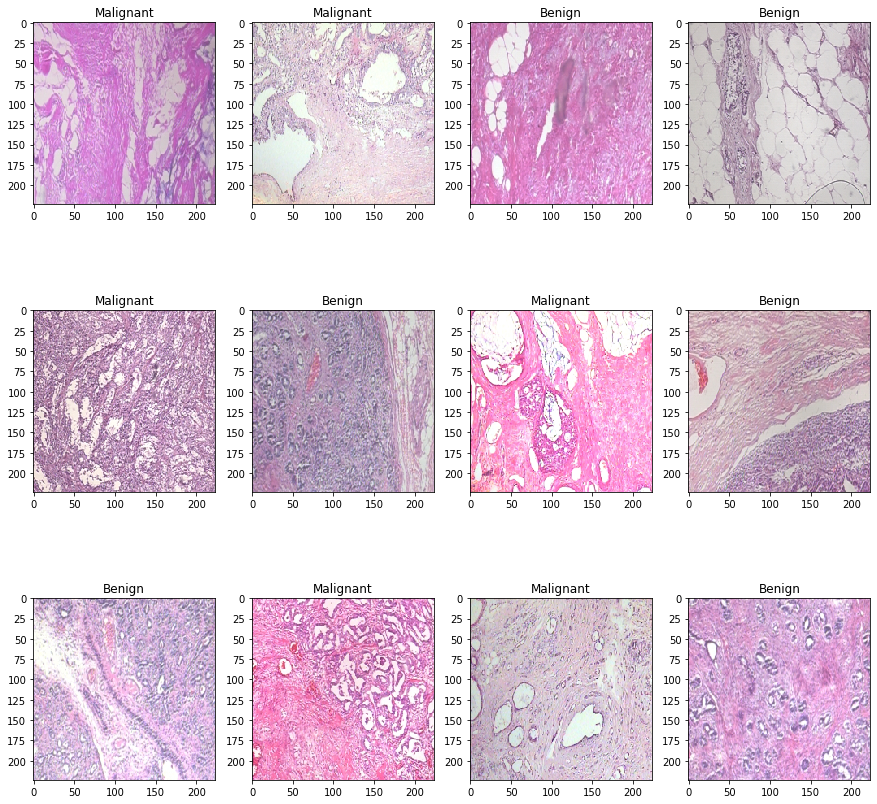

In [18]:

# # Display first 15 images, and how they are classified
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

### Image Data Generator

In [19]:
from keras.preprocessing.image import ImageDataGenerator

In [20]:
BATCH_SIZE = 16

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=[0.5,1.0],  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        brightness_range=[0.2,1.0],
        shear_range=0.2,
)


## ResNet50 model

In [21]:
#define a model
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

In [22]:
from keras import backend as K

In [23]:
import gc

In [24]:
from keras.applications import ResNet50

In [25]:
from keras.models import Sequential

In [26]:
K.clear_session()
gc.collect()
resnet = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)
model = build_model(resnet ,lr = 1e-4)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,600,002
Trainable params: 23,542,786
Non-trainable params: 57,216
_________________________________________________________________


In [28]:
from keras.callbacks import ReduceLROnPlateau, Callback, ModelCheckpoint, TensorBoard

In [29]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

## Training and Evaluation

In [30]:
history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/20
17/16 [===============================] - ETA: -10s - loss: 0.6460 - accuracy: 0.6887
Epoch 00001: val_accuracy improved from -inf to 0.58462, saving model to weights.best.hdf5
17/16 [===============================] - 221s 13s/step - loss: 0.6460 - accuracy: 0.6887 - val_loss: 0.8691 - val_accuracy: 0.5846
Epoch 2/20
17/16 [===============================] - ETA: -8s - loss: 0.3773 - accuracy: 0.8405
Epoch 00002: val_accuracy did not improve from 0.58462
17/16 [===============================] - 168s 10s/step - loss: 0.3773 - accuracy: 0.8405 - val_loss: 0.8895 - val_accuracy: 0.5846
Epoch 3/20
17/16 [===============================] - ETA: -8s - loss: 0.3455 - accuracy: 0.8638
Epoch 00003: val_accuracy did not improve from 0.58462
17/16 [===============================] - 153s 9s/step - loss: 0.3455 - accuracy: 0.8638 - val_loss: 1.3348 - val_accuracy: 0.5846
Epoch 4/20
17/16 [===============================] - ETA: -6s - loss: 0.2854 - accuracy: 0.8949
Epoch 00004: val_ac

In [32]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

<AxesSubplot:>

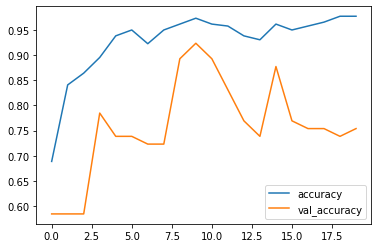

In [33]:
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

<AxesSubplot:>

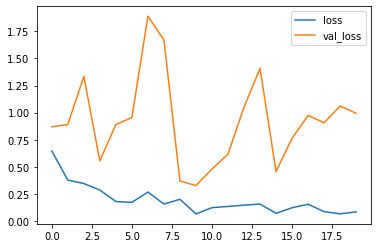

In [34]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

In [35]:
model.load_weights("weights.best.hdf5")

In [36]:
Y_pred = model.predict(X_test)

In [37]:
tta_steps = 8
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

Instructions for updating:
Please use Model.predict, which supports generators.


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:00<00:00,  7.61s/it]


In [44]:
import itertools

Confusion matrix, without normalization
[[16 14]
 [16 14]]


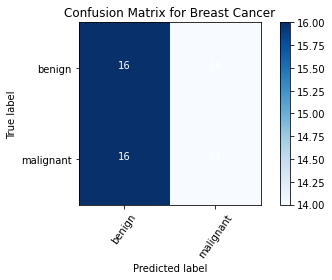

In [45]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Matrix for Breast Cancer')

Confusion matrix, without normalization
[[20 10]
 [21  9]]


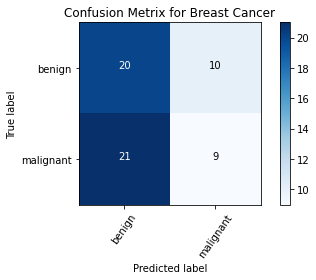

In [46]:
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Breast Cancer')

In [40]:
from sklearn.metrics import classification_report
classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

'              precision    recall  f1-score   support\n\n           0       0.49      0.67      0.56        30\n           1       0.47      0.30      0.37        30\n\n    accuracy                           0.48        60\n   macro avg       0.48      0.48      0.47        60\nweighted avg       0.48      0.48      0.47        60\n'

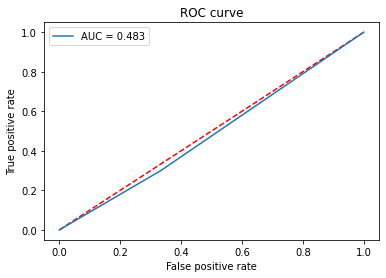

In [41]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

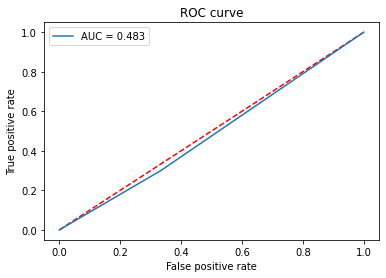

In [42]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

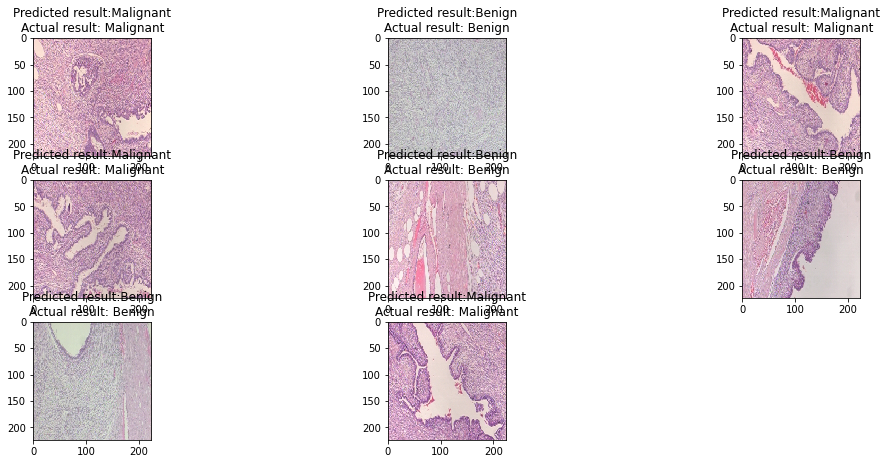

In [43]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Display first 8 images of benign
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 3
rows = 4

def Transfername(namecode):
    if namecode==1:
        return "Malignant"
    else:
        return "Benign"

for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()